# Basic NLP Classification Model

<span> This notebook describes a simple TFIDF model that can be used to classify an email as a business or personal email given a corpus from the email's subject body.

### Import Preliminaries


In [46]:
# Import Modules
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns

from matplotlib import rcParams, gridspec
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report,
                             f1_score, precision_score, recall_score,
                             precision_recall_fscore_support, roc_auc_score)
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight

# Warning Configuration
warnings.filterwarnings('ignore')



### Funcitons

In [47]:
# Retrieve EMmail Names
def retrieve_email_names(path:str) -> list:
    '''
    This function with search the provided file path and return a
    list of all the files names within path
    
    Parameters
    ----------
    path: a string input specifying the file path
    
    Examples
    ----------
    >>>> retrieve_email_names/kavi/emails/business')
    >>>> retrieve_email_names(/kavi/emails/personal')
    '''
    
    email_names = []
    for root, dirs, files in os.walk(path):
        for file in files:
            email_names.append(file)
    return email_names


# Retriveve Email Content from Directory
def retrieve_email_content(path):
    '''
    This function with search the provided file path and return a 
    list of corpus for all the files witin the directory. Note that
    this function will filter the emails for only the subject lines
    and will note return the email metadata from within this function.
    
    Parameters
    ----------
    path: a string input specifying the file path
    
    Examples
    ---------
    >>>> retrieve_email_content(/kavi/emails/business')
    >>>> retrieve_email_content(/kavi/emails/personal')
    
    '''
    email_content = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = path+'/'+file
            with open(file_path,  encoding='windows-1252') as email_file:
                email = email_file.read()
                start_pos = email.find('\n\n')
                end_pos = email.find('<MARKUP id')
                subject = email[start_pos:end_pos]
                email_content.append(subject)
    return email_content


# Plot a confusion matrix with matplotlib given a confusion matrix
def plot_confusion_matrix(cm, classes, fontsize=20,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    THE MAIN CONFUSION MATRIX, KAVI DON'T DELTETE BY ACCIDENT AGAIN. Function plots a 
    confusion matrix given a cm matrix and class names

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ---------
    >>>>

    plot_confusion_matrix(
    cm,
    classes,
    fontsize=25,
    normalize=True,
    title=model.name.capitalize() + ': Test Set',
    cmap=plt.cm.Greens)

    '''
    cm_num = cm
    cm_per = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        None
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot perentage
        text = format(cm_per[i, j], '.5f')
        text = text + '%'
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='baseline',
            horizontalalignment='center',
            color=color)
        # Plot numeric
        text = format(cm_num[i, j], 'd')
        text = '\n \n' + text
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='center',
            color=color)

    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return None

# Confusion matrix plotting function or normal classifier
def plot_confusion_normal(model, classes, name, train_x, train_y,
                          test_x, test_y, cmap=plt.cm.Greens):
    '''
    Fuction plota grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_normal(xg_model, train_x, train_y)
    >>>> plot_confusion_normal(rf_model, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Test Set',
        cmap=cmap)

    return None        

def grid_search_groupby(results: pd.DataFrame, param_1: str, param_2: str) -> pd.DataFrame:
    '''
    Create a aggregated dataframe from the grid search results use the two
    hyper paramters that we pass into the function. We will be using this
    function to plot heatmaps from our grid search.
    
    Parameters
    ----------
    results: DataFrame of Grid Score results.
    
    Examples
    ----------
    >>> (grid_search_groupby(results,'max_depth','n_estimators')
    >>> grid_search_groupby(results,'max_leaf_nodes','n_estimators')
    '''
    assert (type(results) ==  type(pd.DataFrame())), 'results should be a pandas.core.frame.DataFrame'
    assert (type(param_1) == str), 'param_1 should be a string'
    assert (type(param_2) == str), 'param_2 should be a string'
    
    params_df  = pd.DataFrame.from_dict(list(results.params.values))
    mean_test_score = results.mean_test_score
    result_shrt_df = pd.concat([mean_test_score, params_df], axis=1)
    result_groupby = result_shrt_df.groupby([param_1, param_2])['mean_test_score'].mean().unstack()
    return result_groupby

### Import Data

Aggregate all the emails from the business and personal sub directories. Strip any information before the first new line character and everythin after the first `<<MARKUP id=alex...>` HTML tag. When we import the we filter the string for the only the information within the body. Next I strip any unecassary information from the beforing aggregating the data into our training dataset.

In [48]:
# Local File Path to business and personal email data
business = '/Users/kavi/Google Drive/Job/Technical Tests/Behavox/Data/business'
personal = '/Users/kavi/Google Drive/Job/Technical Tests/Behavox/Data/personal'

# Generate a list of files
business_email_names = retrieve_email_names(business)
personal_email_names = retrieve_email_names(personal)
business_email_content = retrieve_email_content(business)
personal_email_content = retrieve_email_content(personal)

# Print the length of the returned lists
print('Business Email Name Length:', len(business_email_names))
print('Business Email Concent Length:', len(business_email_content))
print('Personal Email Name Length', len(personal_email_names))
print('Personal EMail Coentent Length', len(personal_email_content))

Business Email Name Length: 4871
Business Email Concent Length: 4871
Personal Email Name Length 1855
Personal EMail Coentent Length 1855


In [49]:
# Appending List Data into a Single dataframe
# Targt Values: Business Email = 0, Personal Email = 1
email_target = [0]*len(business_email_names) + [1]*len(personal_email_names)
email_names = business_email_names + personal_email_names
email_content = business_email_content + personal_email_content

# Let Combiine our data into a single dataset
data = pd.DataFrame(data={
    'name': email_names,
    'content': email_content,
    'target': email_target
})

# View the head of the dataframe
data.head()

,name,content,target
0,maildir_cash-m_inbox_287,\n\nMichelle - can you respond? I haven't see...,0
1,maildir_guzman-m_notes_inbox_916,\n\nHey Guys.\n\nBe cautious when doing a NP/M...,0
2,maildir_taylor-m_notes_inbox_1683,\n\nMark:\n\nHere is a draft of what I propose...,0
3,maildir_sanders-r_notes_inbox_182,\n\nAttached is an initial draft of an Agreeme...,0
4,maildir_shackleton-s_notes_inbox_1975,\n\nClint/Sara-\n\nI read the UBS & CSFB confi...,0


##### Encoding Values

In [50]:
# Encode our data into numpy arrays 
X = data.content.values
y = data.target.values

# Train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Compute Sample Weights
weights = compute_sample_weight(class_weight='balanced', y=y_train)

### Build Pipeline

In [51]:
# Building a simple for the model pipeline 
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgdclassifier', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),], )

### Pipeline Evaluation

In [52]:
# Fit our model
sgd_pipeline.fit(X_train,y_train, **{'sgdclassifier__sample_weight':weights})
sgd_pred = sgd_pipeline.predict(X_train)

##### Crossvalidation Score

In [53]:
# Calculate the cross validation score of the model
scores = cross_validate(sgd_pipeline, X_train, y_train, 
                         cv=10, 
                         fit_params={'sgdclassifier__sample_weight':weights},
                         scoring=['accuracy','precision','recall','f1','roc_auc'],)

# Cross Validation Scores
scores_df = pd.DataFrame(scores).T
scores_df['Mean'] = scores_df.mean(axis=1)
scores_df['Mean']

fit_time           0.770008
score_time         0.415241
test_accuracy      0.953013
train_accuracy     0.970791
test_precision     0.883514
train_precision    0.915353
test_recall        0.955099
train_recall       0.984391
test_f1            0.917717
train_f1           0.948606
test_roc_auc       0.987603
train_roc_auc      0.995948
Name: Mean, dtype: float64

##### Confusion Matrix

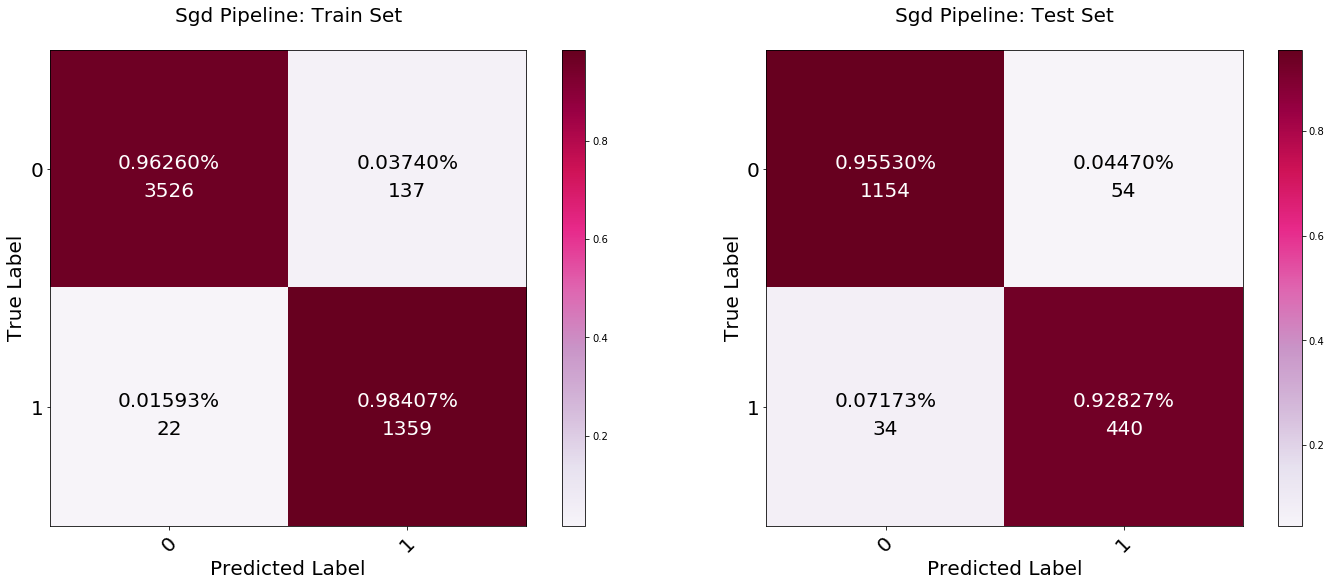

In [54]:
# Plot Confusion Matrix
plot_confusion_normal(model=sgd_pipeline, classes=[0,1], 
                      name = 'SGD Pipeline',
                      train_x=X_train,
                      test_x=X_test,
                      train_y=y_train, test_y=y_test,
                      cmap= plt.cm.PuRd)

##### Pipeline Grid Search

In [55]:
# Setting up the grid
grid = {'sgdclassifier__penalty': ['l2','l1','elasticnet',],
        'sgdclassifier__loss': ['hinge', 'log', 'modified_huber', 
                 'squared_hinge', 'perceptron'],
        'sgdclassifier__alpha':[0,0.00001,0.0001,0.001,0.01,0.1,1]}

# Initialize with GridSearchCV with grid
grid_search = GridSearchCV(estimator=sgd_pipeline, param_grid=grid, 
                     scoring='accuracy', n_jobs=-1, refit=True, cv=10,
                     return_train_score=True, verbose=0)

# Fit search
grid_search.fit(X,y);

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/kavi/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x103bc3e40, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/kavi/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/kavi/.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x103bc3e40, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/kavi/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/kavi/.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...0x1a0b7847b8>))>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle IOLoop._run_callback(functools.par...0x1a0b7847b8>))>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_wrapper at 0x1a0b7847b8>),)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_wrapper at 0x1a0b7847b8>))
    754         """Runs a callback with error handling.
    755 
    756         For use in subclasses.
    757         """
    758         try:
--> 759             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x1a0b7847b8>)
    760             if ret is not None:
    761                 from tornado import gen
    762                 # Functions that return Futures typically swallow all
    763                 # exceptions and store them in the Future.  If a Future

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ()
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in <lambda>()
    531             return
    532 
    533         if state & self.socket.events:
    534             # events still exist that haven't been processed
    535             # explicitly schedule handling to avoid missing events due to edge-triggered FDs
--> 536             self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
    537 
    538     def _init_io_state(self):
    539         """initialize the ioloop event handler"""
    540         with stack_context.NullContext():

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=0)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 11, 21, 48, 17, 438816, tzinfo=tzutc()), 'msg_id': 'f9e70e82a63844388e2d48e5b3cb4624', 'msg_type': 'execute_request', 'session': '9d9d60361c2f4785ac50aa213e40609a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f9e70e82a63844388e2d48e5b3cb4624', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'9d9d60361c2f4785ac50aa213e40609a']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 11, 21, 48, 17, 438816, tzinfo=tzutc()), 'msg_id': 'f9e70e82a63844388e2d48e5b3cb4624', 'msg_type': 'execute_request', 'session': '9d9d60361c2f4785ac50aa213e40609a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f9e70e82a63844388e2d48e5b3cb4624', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'9d9d60361c2f4785ac50aa213e40609a'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 11, 21, 48, 17, 438816, tzinfo=tzutc()), 'msg_id': 'f9e70e82a63844388e2d48e5b3cb4624', 'msg_type': 'execute_request', 'session': '9d9d60361c2f4785ac50aa213e40609a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f9e70e82a63844388e2d48e5b3cb4624', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="# Setting up the grid\ngrid = {'sgdclassifier__pe...e, verbose=0)\n\n# Fit search\ngrid_search.fit(X,y);", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-55-fd5ebedc6761>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1a19986630, execution...rue silent=False shell_futures=True> result=None>)
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])
   2908                 code = compiler(mod, cell_name, "single")
-> 2909                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1a0bdcb660, file "<ipython-input-55-fd5ebedc6761>", line 13>
        result = <ExecutionResult object at 1a19986630, execution...rue silent=False shell_futures=True> result=None>
   2910                     return True
   2911 
   2912             # Flush softspace
   2913             if softspace(sys.stdout, 0):

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1a0bdcb660, file "<ipython-input-55-fd5ebedc6761>", line 13>, result=<ExecutionResult object at 1a19986630, execution...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1a0bdcb660, file "<ipython-input-55-fd5ebedc6761>", line 13>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'SGDClassifier()', "# Import Modules\nimport os\nimport itertools\nimpo...g Configuration\nwarnings.filterwarnings('ignore')", "# Retrieve EMmail Names\ndef retrieve_email_names...Set',\n        cmap=cmap)\n\n    return None        ", "# Local File Path to business and personal email...il Coentent Length', len(personal_email_content))", '# Appending List Data into a Single dataframe\n# ...\n})\n\n# View the head of the dataframe\ndata.head()', "# Encode our data into numpy arrays \nX = data.co...sample_weight(class_weight='balanced', y=y_train)", '# Building a simple for the model pipeline \nsgd_...                      max_iter=5, tol=None)),], )', '# Fit our model\nsgd_pipeline.fit(X_train,y_train...eights})\nsgd_pred = sgd_pipeline.predict(X_train)', "# Calculate the cross validation score of the mo...Mean'] = scores_df.mean(axis=1)\nscores_df['Mean']", '# Plot Confusion Matrix\nplot_confusion_normal(mo...=y_test,\n                      cmap= plt.cm.PuRd)', 'SGDClassifier()', "# Setting up the grid\ngrid = {'penalty': 'l2','l...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Setting up the grid\ngrid = {'penalty': ['l2','...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Setting up the grid\ngrid = {'penalty': ['l2','...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Setting up the grid\ngrid = {'penalty': ['l2','...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Import Modules\nimport os\nimport itertools\nimpo...g Configuration\nwarnings.filterwarnings('ignore')", "# Import Modules\nimport os\nimport itertools\nimpo...g Configuration\nwarnings.filterwarnings('ignore')", "# Setting up the grid\ngrid = {'penalty': ['l2','...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Setting up the grid\ngrid = {'sgdclassifier__pe...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", ...], 'Out': {5:                                     name  \
0   ...Sara-\n\nI read the UBS & CSFB confi...       0  , 9: fit_time           0.832957
score_time         0..._roc_auc      0.995073
Name: Mean, dtype: float64, 11: SGDClassifier(alpha=0.0001, average=False, class...ffle=True, tol=None, verbose=0, warm_start=False), 44: fit_time           0.791435
score_time         0..._roc_auc      0.999797
Name: Mean, dtype: float64, 49:                                     name  \
0   ...Sara-\n\nI read the UBS & CSFB confi...       0  , 53: fit_time           0.770008
score_time         0..._roc_auc      0.995948
Name: Mean, dtype: float64}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SGDClassifier': <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>, 'TfidfTransformer': <class 'sklearn.feature_extraction.text.TfidfTransformer'>, 'X': array(["\n\nMichelle - can you respond?  I haven...row.  \n\nThanks,\n\nKay\n"],
      dtype=object), 'X_test': array(['\n\nIn order to document the Merrick con...oughput for 2001?\n\n",
       ''], dtype=object), 'X_train': array(['\n\nGood Morning,\n\nEPE has agreed to p...y's next week.\n\n\n\n\n\n"],
      dtype=object), ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'SGDClassifier()', "# Import Modules\nimport os\nimport itertools\nimpo...g Configuration\nwarnings.filterwarnings('ignore')", "# Retrieve EMmail Names\ndef retrieve_email_names...Set',\n        cmap=cmap)\n\n    return None        ", "# Local File Path to business and personal email...il Coentent Length', len(personal_email_content))", '# Appending List Data into a Single dataframe\n# ...\n})\n\n# View the head of the dataframe\ndata.head()', "# Encode our data into numpy arrays \nX = data.co...sample_weight(class_weight='balanced', y=y_train)", '# Building a simple for the model pipeline \nsgd_...                      max_iter=5, tol=None)),], )', '# Fit our model\nsgd_pipeline.fit(X_train,y_train...eights})\nsgd_pred = sgd_pipeline.predict(X_train)', "# Calculate the cross validation score of the mo...Mean'] = scores_df.mean(axis=1)\nscores_df['Mean']", '# Plot Confusion Matrix\nplot_confusion_normal(mo...=y_test,\n                      cmap= plt.cm.PuRd)', 'SGDClassifier()', "# Setting up the grid\ngrid = {'penalty': 'l2','l...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Setting up the grid\ngrid = {'penalty': ['l2','...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Setting up the grid\ngrid = {'penalty': ['l2','...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Setting up the grid\ngrid = {'penalty': ['l2','...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Import Modules\nimport os\nimport itertools\nimpo...g Configuration\nwarnings.filterwarnings('ignore')", "# Import Modules\nimport os\nimport itertools\nimpo...g Configuration\nwarnings.filterwarnings('ignore')", "# Setting up the grid\ngrid = {'penalty': ['l2','...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", "# Setting up the grid\ngrid = {'sgdclassifier__pe...n_score=True)\n\n# Fit search\ngrid_search.fit(X,y);", ...], 'Out': {5:                                     name  \
0   ...Sara-\n\nI read the UBS & CSFB confi...       0  , 9: fit_time           0.832957
score_time         0..._roc_auc      0.995073
Name: Mean, dtype: float64, 11: SGDClassifier(alpha=0.0001, average=False, class...ffle=True, tol=None, verbose=0, warm_start=False), 44: fit_time           0.791435
score_time         0..._roc_auc      0.999797
Name: Mean, dtype: float64, 49:                                     name  \
0   ...Sara-\n\nI read the UBS & CSFB confi...       0  , 53: fit_time           0.770008
score_time         0..._roc_auc      0.995948
Name: Mean, dtype: float64}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SGDClassifier': <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>, 'TfidfTransformer': <class 'sklearn.feature_extraction.text.TfidfTransformer'>, 'X': array(["\n\nMichelle - can you respond?  I haven...row.  \n\nThanks,\n\nKay\n"],
      dtype=object), 'X_test': array(['\n\nIn order to document the Merrick con...oughput for 2001?\n\n",
       ''], dtype=object), 'X_train': array(['\n\nGood Morning,\n\nEPE has agreed to p...y's next week.\n\n\n\n\n\n"],
      dtype=object), ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/kavi/Documents/Science/Test/Behavox/<ipython-input-55-fd5ebedc6761> in <module>()
      8 grid_search = GridSearchCV(estimator=sgd_pipeline, param_grid=grid, 
      9                      scoring='accuracy', n_jobs=-1, refit=True, cv=10,
     10                      return_train_score=True, verbose=0)
     11 
     12 # Fit search
---> 13 grid_search.fit(X,y);

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=10, error_score='raise',
       ...score=True,
       scoring='accuracy', verbose=0), X=array(["\n\nMichelle - can you respond?  I haven...row.  \n\nThanks,\n\nKay\n"],
      dtype=object), y=array([0, 0, 0, ..., 1, 1, 1]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...d(n_splits=10, random_state=None, shuffle=False)>
        X = array(["\n\nMichelle - can you respond?  I haven...row.  \n\nThanks,\n\nKay\n"],
      dtype=object)
        y = array([0, 0, 0, ..., 1, 1, 1])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Nov 11 13:49:11 2018
PID: 2298                    Python 3.6.5: /Users/kavi/anaconda3/bin/python
...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('vect', Count...
       tol=None, verbose=0, warm_start=False))]), array(["\n\nMichelle - can you respond?  I haven...row.  \n\nThanks,\n\nKay\n"],
      dtype=object), array([0, 0, 0, ..., 1, 1, 1]), {'score': make_scorer(accuracy_score)}, array([ 488,  489,  490, ..., 6723, 6724, 6725]), array([   0,    1,    2,    3,    4,    5,    6,...5050, 5051, 5052, 5053,
       5054, 5055, 5056]), 0, {'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('vect', Count...
       tol=None, verbose=0, warm_start=False))]), array(["\n\nMichelle - can you respond?  I haven...row.  \n\nThanks,\n\nKay\n"],
      dtype=object), array([0, 0, 0, ..., 1, 1, 1]), {'score': make_scorer(accuracy_score)}, array([ 488,  489,  490, ..., 6723, 6724, 6725]), array([   0,    1,    2,    3,    4,    5,    6,...5050, 5051, 5052, 5053,
       5054, 5055, 5056]), 0, {'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('vect', Count...
       tol=None, verbose=0, warm_start=False))]), X=array(["\n\nMichelle - can you respond?  I haven...row.  \n\nThanks,\n\nKay\n"],
      dtype=object), y=array([0, 0, 0, ..., 1, 1, 1]), scorer={'score': make_scorer(accuracy_score)}, train=array([ 488,  489,  490, ..., 6723, 6724, 6725]), test=array([   0,    1,    2,    3,    4,    5,    6,...5050, 5051, 5052, 5053,
       5054, 5055, 5056]), verbose=0, parameters={'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method Pipeline.set_params of Pipeline(me...       tol=None, verbose=0, warm_start=False))])>
        parameters = {'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in set_params(self=Pipeline(memory=None,
     steps=[('vect', Count...
       tol=None, verbose=0, warm_start=False))]), **kwargs={'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'})
    137 
    138         Returns
    139         -------
    140         self
    141         """
--> 142         self._set_params('steps', **kwargs)
        self._set_params = <bound method _BaseComposition._set_params of Pi...       tol=None, verbose=0, warm_start=False))])>
        kwargs = {'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'}
    143         return self
    144 
    145     def _validate_steps(self):
    146         names, estimators = zip(*self.steps)

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py in _set_params(self=Pipeline(memory=None,
     steps=[('vect', Count...
       tol=None, verbose=0, warm_start=False))]), attr='steps', **params={'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'})
     44         names, _ = zip(*getattr(self, attr))
     45         for name in list(six.iterkeys(params)):
     46             if '__' not in name and name in names:
     47                 self._replace_estimator(attr, name, params.pop(name))
     48         # 3. Step parameters and other initilisation arguments
---> 49         super(_BaseComposition, self).set_params(**params)
        self.set_params = <bound method Pipeline.set_params of Pipeline(me...       tol=None, verbose=0, warm_start=False))])>
        params = {'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'}
     50         return self
     51 
     52     def _replace_estimator(self, attr, name, new_val):
     53         # assumes `name` is a valid estimator name

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/base.py in set_params(self=Pipeline(memory=None,
     steps=[('vect', Count...
       tol=None, verbose=0, warm_start=False))]), **params={'sgdclassifier__alpha': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'})
    277                 nested_params[key][sub_key] = value
    278             else:
    279                 setattr(self, key, value)
    280 
    281         for key, sub_params in nested_params.items():
--> 282             valid_params[key].set_params(**sub_params)
        valid_params = {'memory': None, 'sgdclassifier': SGDClassifier(alpha=0, average=False, class_weig...ue,
       tol=None, verbose=0, warm_start=False), 'sgdclassifier__alpha': 0.001, 'sgdclassifier__average': False, 'sgdclassifier__class_weight': None, 'sgdclassifier__epsilon': 0.1, 'sgdclassifier__eta0': 0.0, 'sgdclassifier__fit_intercept': True, 'sgdclassifier__l1_ratio': 0.15, 'sgdclassifier__learning_rate': 'optimal', ...}
        key.set_params = undefined
        sub_params = {'alpha': 0, 'loss': 'hinge', 'penalty': 'l2'}
    283 
    284         return self
    285 
    286     def __repr__(self):

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py in set_params(self=SGDClassifier(alpha=0, average=False, class_weig...ue,
       tol=None, verbose=0, warm_start=False), *args=(), **kwargs={'alpha': 0, 'loss': 'hinge', 'penalty': 'l2'})
     73         # but we are not allowed to set attributes
     74         self._validate_params(set_max_iter=False)
     75 
     76     def set_params(self, *args, **kwargs):
     77         super(BaseSGD, self).set_params(*args, **kwargs)
---> 78         self._validate_params(set_max_iter=False)
        self._validate_params = <bound method BaseSGD._validate_params of SGDCla...e,
       tol=None, verbose=0, warm_start=False)>
     79         return self
     80 
     81     @abstractmethod
     82     def fit(self, X, y):

...........................................................................
/Users/kavi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py in _validate_params(self=SGDClassifier(alpha=0, average=False, class_weig...ue,
       tol=None, verbose=0, warm_start=False), set_max_iter=False)
     94             raise ValueError("alpha must be >= 0")
     95         if self.learning_rate in ("constant", "invscaling"):
     96             if self.eta0 <= 0.0:
     97                 raise ValueError("eta0 must be > 0")
     98         if self.learning_rate == "optimal" and self.alpha == 0:
---> 99             raise ValueError("alpha must be > 0 since "
    100                              "learning_rate is 'optimal'. alpha is used "
    101                              "to compute the optimal learning rate.")
    102 
    103         # raises ValueError if not registered

ValueError: alpha must be > 0 since learning_rate is 'optimal'. alpha is used to compute the optimal learning rate.
___________________________________________________________________________

In [34]:
# Print the best grid search score
print('Accuracy of best parameters: %.5f'%grid_search.best_score_)
print('Best parameters: %s' %grid_search.best_params_)

Accuracy of best parameters: 0.96268
Best parameters: {'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'}


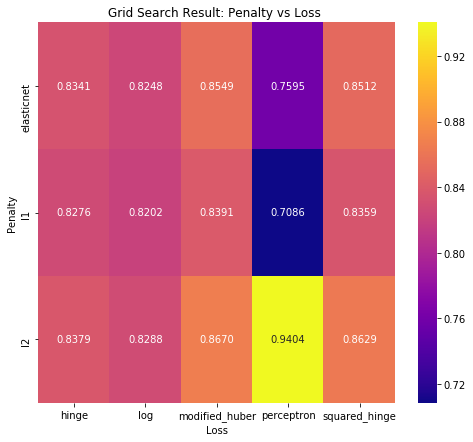

In [35]:
# Plot Grid Seach Results
results = pd.DataFrame(grid_search.cv_results_)
result_groupby_1 = grid_search_groupby(results,
                                       'sgdclassifier__penalty',
                                       'sgdclassifier__loss')

rcParams['figure.figsize'] = (8.0, 7.0)
sns.heatmap(grid_search_groupby(results,'sgdclassifier__penalty',
                                'sgdclassifier__loss'),
           cmap='plasma', annot=True, fmt='.4f');
plt.title('Grid Search Result: Penalty vs Loss ');
plt.xlabel('Loss')
plt.ylabel('Penalty');

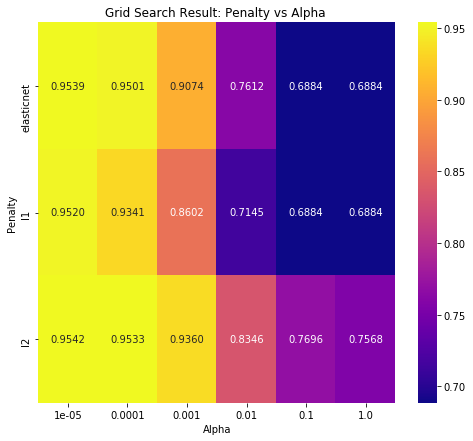

In [38]:
# Plot Grid Seach Results
results = pd.DataFrame(grid_search.cv_results_)
result_groupby_1 = grid_search_groupby(results,
                                       'sgdclassifier__penalty',
                                       'sgdclassifier__alpha')

rcParams['figure.figsize'] = (8.0, 7.0)
sns.heatmap(grid_search_groupby(results,'sgdclassifier__penalty',
                                'sgdclassifier__alpha'),
           cmap='plasma', annot=True, fmt='.4f');
plt.title('Grid Search Result: Penalty vs Alpha ');
plt.xlabel('Alpha')
plt.ylabel('Penalty');

### Final Pipeline

In [39]:
print('Best parameters: %s' %grid_search.best_params_)

Best parameters: {'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l2'}


In [42]:
# Building a simple for the model pipeline 
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgdclassifier', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=0.0001, random_state=42,
                          max_iter=5, tol=None)),], )

In [43]:
scores = cross_validate(sgd_pipeline, X_train, y_train, 
                         cv=10, 
                         fit_params={'sgdclassifier__sample_weight':weights},
                         scoring=['accuracy','precision','recall','f1','roc_auc'],)


In [44]:
# Cross Validation Scores
scores_df = pd.DataFrame(scores).T
scores_df['Mean'] = scores_df.mean(axis=1)
scores_df['Mean']

fit_time           0.791435
score_time         0.447466
test_accuracy      0.961337
train_accuracy     0.996652
test_precision     0.927987
train_precision    0.989584
test_recall        0.929578
train_recall       0.998126
test_f1            0.928499
train_f1           0.993836
test_roc_auc       0.987265
train_roc_auc      0.999797
Name: Mean, dtype: float64

Author: Kavi Sekhon